In [1]:
import numpy as np
import pandas as pd 
from collections import Counter

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.patheffects as PathEffects


import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

import torch
from fastai.vision import *
from fastai.metrics import *

np.random.seed(7)
torch.cuda.manual_seed_all(7)

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
main_path = Path('/home/jupyter/fashion_mnist/')
main_path.ls()

[PosixPath('/home/jupyter/fashion_mnist/train.csv'),
 PosixPath('/home/jupyter/fashion_mnist/train'),
 PosixPath('/home/jupyter/fashion_mnist/test.csv'),
 PosixPath('/home/jupyter/fashion_mnist/submission.csv'),
 PosixPath('/home/jupyter/fashion_mnist/More experimentation.ipynb'),
 PosixPath('/home/jupyter/fashion_mnist/test'),
 PosixPath('/home/jupyter/fashion_mnist/models'),
 PosixPath('/home/jupyter/fashion_mnist/TSNE_probabilities.jpg'),
 PosixPath('/home/jupyter/fashion_mnist/.ipynb_checkpoints'),
 PosixPath('/home/jupyter/fashion_mnist/Identify the apparels.ipynb'),
 PosixPath('/home/jupyter/fashion_mnist/Clustered visualization.ipynb'),
 PosixPath('/home/jupyter/fashion_mnist/A fresh approach (Best one till now).ipynb')]

In [3]:
train = pd.read_csv(main_path/'train.csv')

In [4]:
databunch = ImageList.from_df(train, path=main_path, folder='train', suffix='.png')\
            .split_by_rand_pct(0.1)\
            .label_from_df()\
            .transform(get_transforms(do_flip=True), size=28)\
            .databunch(path='.', bs=256, device= torch.device('cuda:0'))\
            .normalize()

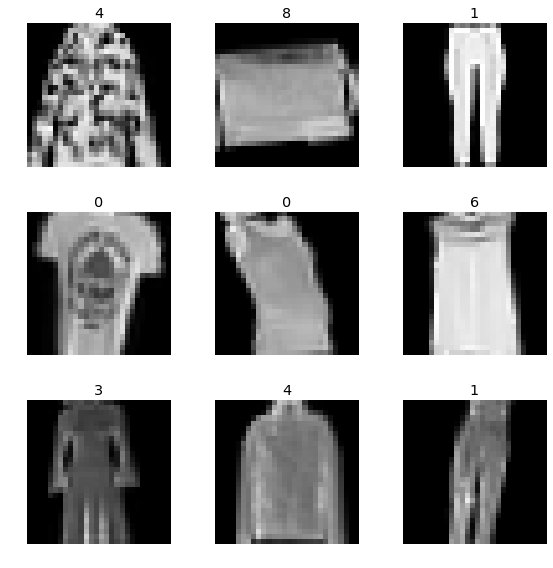

In [5]:
databunch.show_batch(rows=3, figsize=(8, 8))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


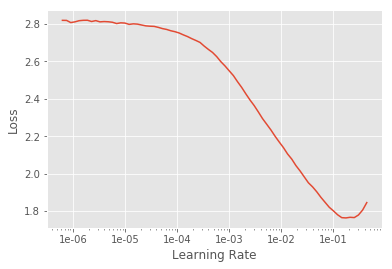

In [8]:
learner = cnn_learner(databunch, models.resnet50, 
                      metrics=[error_rate, accuracy]).to_fp16()

learner.lr_find()
learner.recorder.plot()

In [7]:
learner.unfreeze()
learner.fit_one_cycle(10, max_lr=(1e-4, 5e-3, 3e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.452490,0.401109,0.140667,0.859333,00:41
1,0.432129,0.443141,0.138833,0.861167,00:35
2,0.393718,0.311950,0.106000,0.894000,00:35
3,0.358707,0.309628,0.106500,0.893500,00:35
4,0.327463,0.290832,0.102167,0.897833,00:35
5,0.284972,0.269949,0.093667,0.906333,00:35
6,0.249511,0.242989,0.084833,0.915167,00:35
7,0.227898,0.219111,0.079833,0.920167,00:35
8,0.202462,0.214452,0.077333,0.922667,00:35
9,0.190309,0.208492,0.076667,0.923333,00:35


In [8]:
learner.save('tsne-visuals')

In [ ]:
learner = cnn_learner(databunch, models.resnet50, 
                      metrics=[error_rate, accuracy]).to_fp16()

learner.load('tsne-visuals')

In [6]:
interp = ClassificationInterpretation.from_learner(learner, ds_type=DatasetType.Fix)

In [7]:
pred_probs = interp.probs
y_true = interp.y_true

In [54]:
learner.data.train_ds.classes[np.argmax(to_np(F.softmax(pred_probs[256], dim=0)))]

6

In [55]:
learner.data.train_ds.classes[to_np(y_true[256])]

6

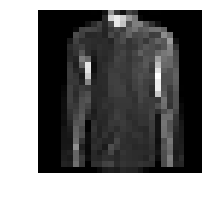

In [56]:
show_image(learner.data.train_ds.x[256])

In [14]:
# https://www.datacamp.com/community/tutorials/introduction-t-sne

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.show()
    #return f, ax, sc, txts

In [58]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca_result = pca.fit_transform(pred_probs)

In [60]:
pca_result[:,0].shape

(54000,)

In [61]:
pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

In [62]:
pca.explained_variance_ratio_

array([0.12348 , 0.122236, 0.122026, 0.121258])

In [66]:
pca_df['1_2_sum'] = pca_df['pca1'] + pca_df['pca2']
pca_df['3_4_sum'] = pca_df['pca3'] + pca_df['pca4']

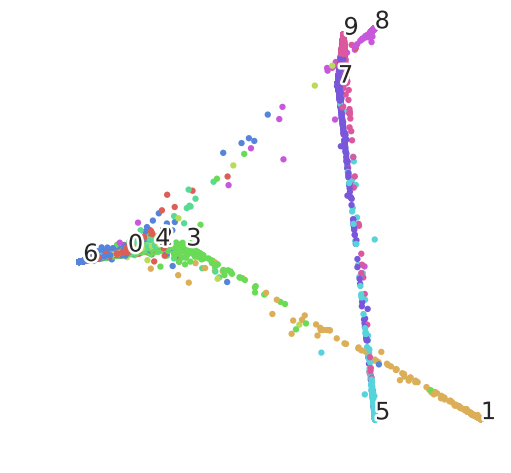

In [67]:
top_two_comp = pca_df[['1_2_sum','3_4_sum']]
fashion_scatter(top_two_comp.values,y_true.numpy())

In [68]:
from sklearn import manifold

probs_trans = manifold.TSNE(n_components=2, perplexity=15).fit_transform(pred_probs)

In [69]:
prob_df = pd.DataFrame(np.concatenate((probs_trans, 
                                       y_true[:,None]), axis=1), columns=['x','y','labels'])

prob_df.head()

,x,y,labels
0,-59.310642,41.492119,9.0
1,1.514790,-25.903364,0.0
2,-5.294839,7.991180,3.0
3,-3.124616,-38.521839,0.0
4,36.692768,-21.535612,2.0


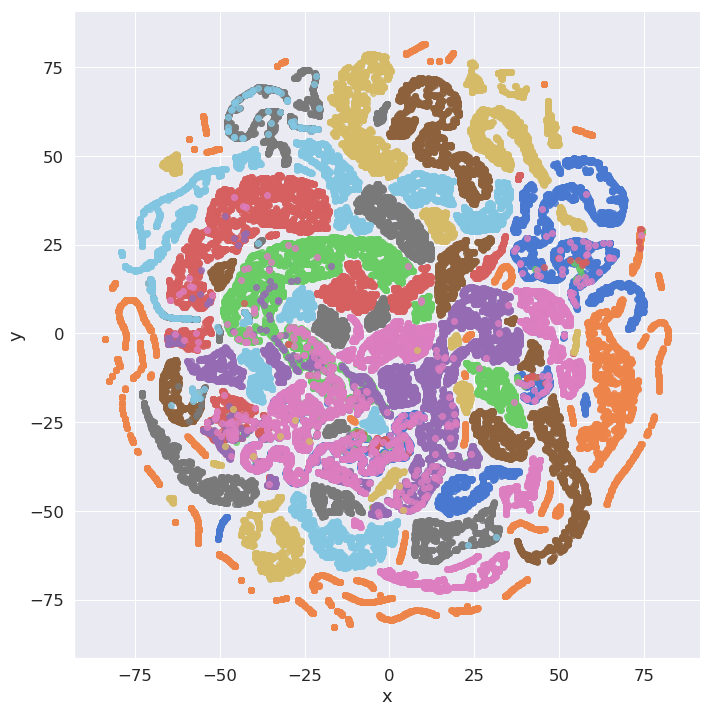

In [70]:
g = sns.lmplot('x', 'y', data=prob_df, hue='labels', fit_reg=False, legend=False, height=10)

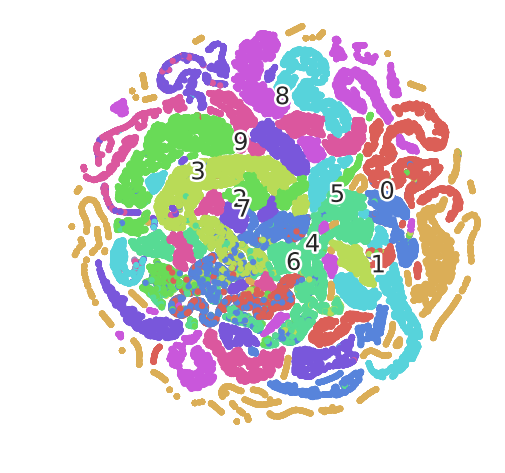

In [72]:
fashion_scatter(probs_trans, y_true.numpy())

In [10]:
pca_10 = PCA(n_components=10)
pca_result_10 = pca_10.fit_transform(pred_probs)

In [12]:
fashion_pca_tsne = manifold.TSNE(n_components=2, perplexity=15).fit_transform(pca_result_10)

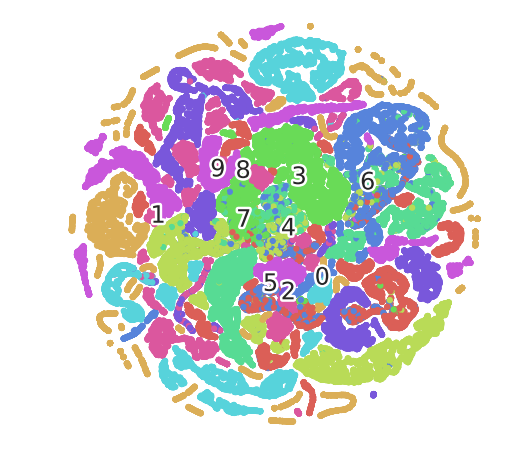

In [15]:
fashion_scatter(fashion_pca_tsne, y_true.numpy())